In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
    NegativeLowerConfidenceBound, MaxValueEntropySearch

from utils import get_array_and_len, x_scaler, x_descaler, get_closest_array, \
    define_parameter_space_discrete2, get_rbf_kernel, get_gpr_model, get_matern52_kernel, \
    generate_visualization_efficiency_vs_ml_conditions, generate_contour_plot, \
    generate_visualization_suggested_process_conditions, compute_group_means
from utils import ScaledProbabilityOfFeasibility, ProbabilisticConstraintBayesianOptimizationLoop2

np.random.seed(10)

In [28]:
file_path = './器件薄膜数据.xlsx'

# Load the first sheet
sheet_name = '2022_07_15_film'
df_film_20220715 = pd.read_excel(file_path, sheet_name=sheet_name)

# Renaming the columns
df_film_20220715.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Load the second sheet
sheet_name = '2022_07_21_film'
df_film_20220721 = pd.read_excel(file_path, sheet_name=sheet_name)

# Renaming the columns
df_film_20220721.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Load the third sheet
sheet_name = '2022_08_01_film'
df_film_20220801 = pd.read_excel(file_path, sheet_name=sheet_name)

# Renaming the columns
df_film_20220801.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Load the third sheet
sheet_name = '2022_08_22_film'
df_film_20220822 = pd.read_excel(file_path, sheet_name=sheet_name)

# Renaming the columns
df_film_20220822.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Load the third sheet
sheet_name = '2022_08_29_film'
df_film_20220829 = pd.read_excel(file_path, sheet_name=sheet_name)

# Renaming the columns
df_film_20220829.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Merge the DataFrames
df_film = pd.concat([df_film_20220715, df_film_20220721, df_film_20220801, df_film_20220822, df_film_20220829], ignore_index=True)

# Filter the successful conditions
success_conditions = df_film[df_film['Success or Fail'] == 1]['Condition'].values

# Display the DataFrame without the 'Success or Fail' column
df_film_filtered = df_film[df_film['Success or Fail'] == 1].drop(columns=['Success or Fail'])

# Display the DataFrame or without the 'Success or Fail' column
df_film.iloc[:, :]

,Condition,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%),Success or Fail
0,1,0,100,0,0.8,110,200,20,25,30,0
1,2,100,0,0,1.3,100,250,25,25,30,1
2,3,0,0,100,1.2,115,100,20,25,30,0
3,4,15,85,0,1.4,125,100,15,25,30,1
4,5,0,15,85,1.1,135,120,17,25,30,1
...,...,...,...,...,...,...,...,...,...,...,...
95,95,5,85,15,1.4,130,50,20,20,20,1
96,96,5,85,15,1.4,140,60,20,20,20,1
97,97,5,85,15,1.5,130,50,15,20,20,1
98,98,10,90,40,1.5,120,130,5,20,20,1


In [29]:
# Read the first sheet from the Excel file
file_path = './器件薄膜数据.xlsx'
sheet_name = '2022_07_15_device'
df_device_20220715 = pd.read_excel(file_path, sheet_name=sheet_name)

# Read the second sheet from the Excel file
sheet_name = '2022_07_21_device'
df_device_20220721 = pd.read_excel(file_path, sheet_name=sheet_name)

# Read the second sheet from the Excel file
sheet_name = '2022_08_01_device'
df_device_20220801 = pd.read_excel(file_path, sheet_name=sheet_name)

# Read the second sheet from the Excel file
sheet_name = '2022_08_22_device'
df_device_20220822 = pd.read_excel(file_path, sheet_name=sheet_name)

# Read the second sheet from the Excel file
sheet_name = '2022_08_29_device'
df_device_20220829 = pd.read_excel(file_path, sheet_name=sheet_name)

# Define a function to preprocess the data
def preprocess_device_data(df):
    # Rename the columns
    df.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)',
                  'Voc(V)', 'FF(%)', 'Eff(%)', 'Jsc(mA/cm^2)']
    return df

# Preprocess the data from both sheets
df_device_20220715 = preprocess_device_data(df_device_20220715)
df_device_20220721 = preprocess_device_data(df_device_20220721)
df_device_20220801 = preprocess_device_data(df_device_20220801)
df_device_20220822 = preprocess_device_data(df_device_20220822)
df_device_20220829 = preprocess_device_data(df_device_20220829)
# Merge the DataFrames
df_device = pd.concat([df_device_20220715, df_device_20220721, df_device_20220801, df_device_20220822, df_device_20220829], ignore_index=True)

# Filter out rows with 'Y' in the 'Condition' column
df_device = df_device[df_device['Condition'] != 'Y']

# Sort the DataFrame and remove duplicate 'Condition' rows, keeping the last occurrence
df_device = df_device.sort_values(by=['Condition', 'Jsc(mA/cm^2)']).drop_duplicates('Condition', keep='last', ignore_index=True)

# Filter the DataFrame to only include rows with 'Condition' in the success_conditions list
# Assuming success_conditions is defined
df_device = df_device[df_device['Condition'].isin(success_conditions)]

# Display the DataFrame
df_device

,Condition,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%),Voc(V),FF(%),Eff(%),Jsc(mA/cm^2)
1,2,100,0,0,1.30,100,250,25,25,30,0.936879,65.7897,16.2007,26.284000
3,4,15,85,0,1.40,125,100,15,25,30,0.945263,71.2711,17.5802,26.095100
4,5,0,15,85,1.10,135,120,17,25,30,1.003680,74.1679,18.9736,25.488000
5,6,15,85,0,1.50,145,100,15,25,30,0.965233,63.3308,15.9407,26.077100
6,7,0,85,15,1.65,155,50,15,25,30,1.011440,77.0517,20.0879,25.775800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,5,85,15,1.40,130,50,20,20,20,1.120190,76.8394,22.0017,25.561200
95,96,5,85,15,1.40,140,60,20,20,20,1.099300,75.3467,20.8716,25.198700
96,97,5,85,15,1.50,130,50,15,20,20,1.124780,81.1070,22.7332,24.919200
97,98,10,90,40,1.50,120,130,5,20,20,1.121710,80.0501,23.0049,25.619900


In [30]:
# Load the dataset
df_previous = pd.read_excel("./限制性数据.xlsx")

# Change the column names
df_previous.columns = [
    '',
    'NMP (mL)',
    'DMF (mL)',
    'DMSO (mL)',
    'Perovskite concentration (M)',
    'Annealing temperature (℃)',
    'Vacuum Pressure (Pa)',
    'Vacuum Pressure time (s)',
    'Temperature (℃)',
    'Humidity (%)',
    'Voc(V)',
    'FF(%)',
    'Eff(%)',
    'Jsc(mA/cm^2)'
]

# Remove the first column
df_previous = df_previous.iloc[:, 1:]

#df_previous

In [31]:
## Total process conditions: NMP x DMF x DMSO x PC x AT x VP x VT x T = 1871100000 conditions -> incorrect

NMP_options = np.arange(0,105,5) 
DMF_options = np.arange(0,105,5)
DMSO_options = np.arange(0,105,5)
PC_options = np.arange(0.8,1.9,0.1)
AT_options = np.arange(100,180,10)
VP_options = np.arange(20,360,10)
VT_options = np.arange(0,55,5)
T_options = np.arange(15,35,5)
humidity_options = np.arange(15,50,5)

# true number of conditions
print(len(NMP_options) * len(DMF_options) * len(DMSO_options) * len(PC_options) * len(AT_options)
     * len(VP_options) * len(VT_options) * len(T_options) * len(humidity_options))

# needed for scaling
search_space = [NMP_options, DMF_options,
DMSO_options, PC_options,
AT_options, VP_options,
VT_options, T_options, humidity_options]

8534344896


In [32]:
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = define_parameter_space_discrete2(NMP_options, DMF_options, DMSO_options, PC_options, AT_options, \
                                         VP_options, VT_options, T_options, humidity_options)

In [49]:
# Preprocess your data
x_init = x_scaler(df_device.iloc[:, 1:10].values, search_space)
y_init = np.transpose([df_device.iloc[:, -2].values])
xc_init = x_scaler(df_film.iloc[:, 1:-1].values, search_space)
yc_init = np.transpose([df_film.iloc[:, -1].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_scaler(df_previous.iloc[:,0:9].values, search_space)
Yc2 = np.transpose([df_previous.iloc[:,-2].values])

# get objective model
input_dim = len(X[0])
ker = get_matern52_kernel(input_dim)
model_gpy = get_gpr_model(X[:-40], Y[:-40], ker, set_noise=True)
objective_model = GPyModelWrapper(model_gpy)

# get constraint model 1
input_dim_c = len(Xc[0])
ker_c = get_rbf_kernel(input_dim_c)
yc_offset = 0.5 # constraint acquisition computes the probability of < 0
gpy_constraint_model = get_gpr_model(Xc, Yc-yc_offset, ker_c) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

# get_constraint_model 2
input_dim_c2 = len(Xc2[0])
ker_c2 = get_rbf_kernel(input_dim_c2)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of < 0
gpy_constraint_model2 = get_gpr_model(Xc2, Yc2-yc2_offset, ker_c2) 
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


In [50]:
print(len(Y))

89


In [51]:
objective_model.model.kern.lengthscale

index,GP_regression.Mat52.lengthscale,constraints,priors
[0],0.99999999,"0.1,1.0",
[1],1.00000000,"0.1,1.0",
[2],1.00000000,"0.1,1.0",
[3],1.00000000,"0.1,1.0",
[4],0.99999977,"0.1,1.0",
[5],0.76174955,"0.1,1.0",
[6],1.00000000,"0.1,1.0",
[7],0.76710518,"0.1,1.0",
[8],1.00000000,"0.1,1.0",


NameError: name 'y_pred' is not defined

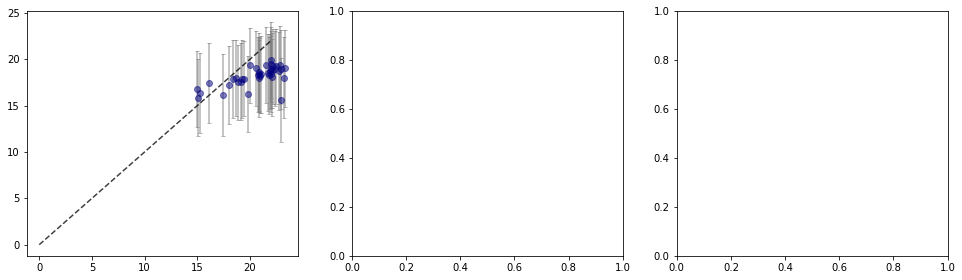

In [52]:
f_obj_old =  objective_model.model.predict
f_cons1_old = constraint_model1.model.predict
f_cons2_old = constraint_model2.model.predict

y_pred_old, y_uncer_old = f_obj_old(X[-40:])
y_pred_old = -y_pred_old[:,-1]
y_uncer_old = np.sqrt(y_uncer_old[:,-1])

yc_pred_old, yc_uncer_old = f_cons1_old(Xc[-40:])
yc_pred_old = -yc_pred_old[:,-1]+yc_offset
yc_uncer_old = np.sqrt(yc_uncer_old[:,-1])

yc2_pred_old, yc2_uncer_old = f_cons2_old(Xc2[-40:])
yc2_pred_old = -yc2_pred_old[:,-1]+yc2_offset
yc2_uncer_old = np.sqrt(yc2_uncer_old[:,-1])


from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 18
lims1 = (0, 22)
axes[0].scatter(Y[-40:,-1], y_pred_old, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[-40:,-1], y_pred_old, yerr = y_uncer_old, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
axes[0].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[0].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)

lims2 = (-.1, 1.1)
axes[1].scatter(Yc[:,-1], yc_pred, alpha = 0.6, edgecolor = 'r', c = 'r')
axes[1].errorbar(Yc[:,-1], yc_pred, yerr = yc_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)

axes[1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
title = 'GPR for Binary Film Quality'
axes[1].set_xlabel('Ground Truth Film Quality [%]', fontsize = fs)
axes[1].set_ylabel('Prediction Film Quality [%]', fontsize = fs)
axes[1].set_title(title, fontsize = fs)


lims3 = (0, 17)
axes[2].scatter(Yc2[:,-1], yc2_pred, alpha = 0.5, c = 'darkorange', edgecolor = 'darkorange')
axes[2].errorbar(Yc2[:,-1], yc2_pred, yerr = yc2_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[2].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Yc2[:,-1], yc2_pred))
title = 'GPR for Prev Data' + " (RMSE=%.2f" % rmse_value+' [%])'

axes[2].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[2].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[2].set_title(title, fontsize = fs)

        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

# Start the First Run of the Batch-mode Bayesian Optimization

In [ ]:
import numpy as np
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size=30)

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_descaler(X_new, search_space)

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))


In [ ]:
df_Xnew = pd.DataFrame(X_new, columns = df_film.columns[1:10])
print(len(df_Xnew))
df_Xnew = df_Xnew.drop_duplicates(keep='first')
print(len(df_Xnew))

df_Xnew = df_Xnew[~df_Xnew.apply(tuple, axis=1).isin(df_film[df_film.columns[:10]].apply(tuple, axis=1))]
print(len(df_Xnew))

In [ ]:
df_Xnew

In [ ]:
X_new = x_scaler(df_Xnew.values, search_space)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

# Quick histogram visualization of the newly suggested process conditions

In [ ]:
generate_visualization_suggested_process_conditions(df_Xnew, 4, search_space)

# Visualisation of Efficiency vs ML conditions, and Acquisition¶

In [ ]:
from emukit.core.initial_designs import RandomDesign

f_obj =  objective_model.model.predict       

generate_visualization_efficiency_vs_ml_conditions(X_new, Xc, df_device, df_film, f_obj, \
                                                   acq_fcn, acq_cons, acq_produc, search_space)

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(1000)
x_columns = df_device.iloc[:,1 :10].columns

for i in range(0, input_dim, 1):
    for j in range(0, input_dim-i-1, 1):
        if i != j:
            generate_contour_plot(i, j, x_sampled, f_obj, x_descaler, x_columns, search_space)